# Image Preprocessing

It is relatively common to find figures from case reports that contain multiple images (as it can be appreciated in [this example](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4322375/)). In this notebook, we will see how to split such figures by following these steps:
- Raw Image Download
- Edge Detection
- Image Limit Detection
- Image Slicing
- Full Image Split
- Order Sorting

For this task, we will need to import the *opencv* library:

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

## Raw Image Download

The first step is to import the figure present in the case report. For this, we are going to use EuropePMC's API.

In [1]:
import requests
import shutil
import os

In [59]:
def import_image(pmcid, file_name):
  url = f"https://www.ebi.ac.uk/europepmc/webservices/rest/{pmcid}/supplementaryFiles?includeInlineImage=true"
  r = requests.get(url)

  folder = 'images'
  with open(f'{folder}.zip', 'wb') as f:
    f.write(r.content)
  shutil.unpack_archive(f'{folder}.zip', f'{folder}')

  raw_image_path = f"{folder}/{file_name}"
  image = cv2.imread(raw_image_path)

  return image

In [60]:
image = import_image(pmcid = 'PMC4322375', file_name = 'JCIS-5-6-g003.jpg')

This is how the figure looks like. As we can see, the file contains four images (a-d).

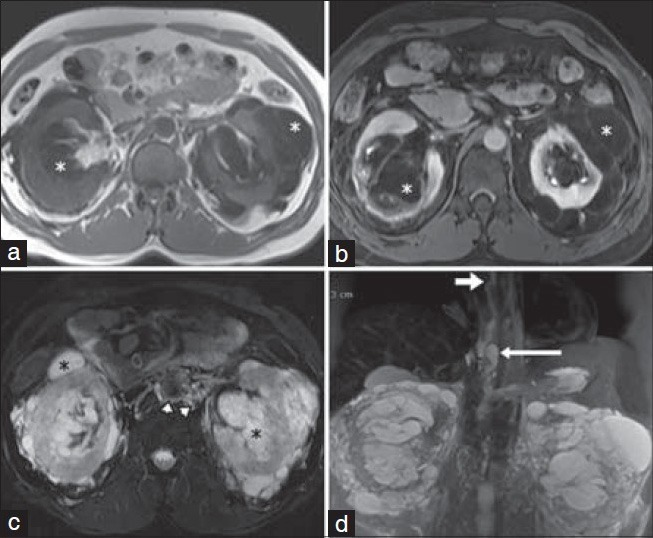

In [61]:
cv2_imshow(image)

## Edge Detection

In order to be able to split the figure, first we need to detect its edges. For this, we blur it using a Gaussian filter, and then we use a Canny edge detector.

In [62]:
def detect_edges(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred_image = cv2.GaussianBlur(gray, (13, 13), 0)
  edges = cv2.Canny(blurred_image, 1, 20)
  return edges

These are the edges of the image. The lines that should be used to split the image into four correspond to the lines with the lowest amounts of edges that are paralel to the axis x or y.

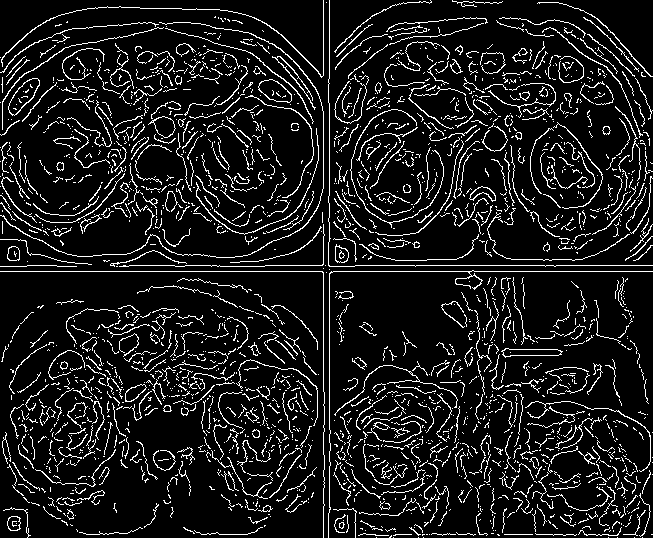

In [63]:
cv2_imshow(detect_edges(image))

## Detection of Limits

In [15]:
import numpy as np

In [27]:
def find_image_limits(edges, axis, edge_threshold = 100):

  # If the amount of edges is higher than the threshold, the value for that axis sum is True.
  axis_sums = np.sum(edges, axis=axis)
  bool_axis_sum = axis_sums >= edge_threshold

  # Indices in which there is transition from one boolean value to the other are the transition indices.
  transition_indices = [0]
  prev_value = None
  for idx, value in enumerate(bool_axis_sum):
    if prev_value is not None and value != prev_value:
      transition_indices.append(idx)
    prev_value = value
  transition_indices.append(idx)

  # Transition indices that are two close one from the other are disregarded.
  image_limits = []
  for i, pixel_index in enumerate(transition_indices):
    if i != len(transition_indices)-1:
      next_pixel_index = transition_indices[i+1]
      if (next_pixel_index - pixel_index) >= 100:
        image_limits.append((pixel_index, next_pixel_index))

  return image_limits

In [64]:
limits = find_image_limits(edges, axis = 0)

When axis is 0, these are the limits found:

In [65]:
limits

[(0, 327), (328, 652)]

## Image Slicing

The *cut_image()* function is created to slice an image given the detected limits.

The *origin* refers to the coordinates of the top-left corner of the input image taking the raw image as a reference. By default, its value is (0, 0).

In [73]:
def cut_image(image, image_limits, axis, origin = (0, 0)):

  im_list = []
  for limit in image_limits:
    if axis == 0:
      new_img = image[:,limit[0]:limit[1]]
      new_origin = (origin[0] + limit[0], origin[1])
    elif axis == 1:
      new_img = image[limit[0]:limit[1],:]
      new_origin = (origin[0], origin[1] + limit[0])
    im_list.append({'image': new_img, 'origin': new_origin})

  return im_list

In [74]:
segmented_images = cut_image(image, limits, axis = 0, origin = (0, 0))

As we can see, the raw image was correctly sliced into two on the x-axis.

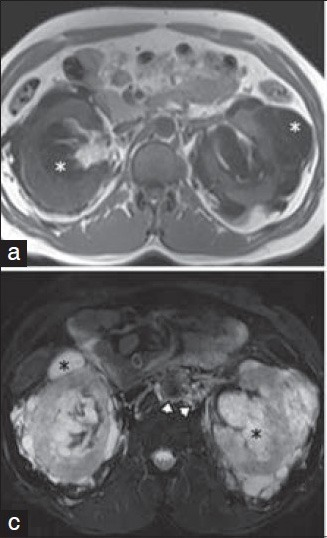

In [75]:
cv2_imshow(segmented_images[0]['image'])

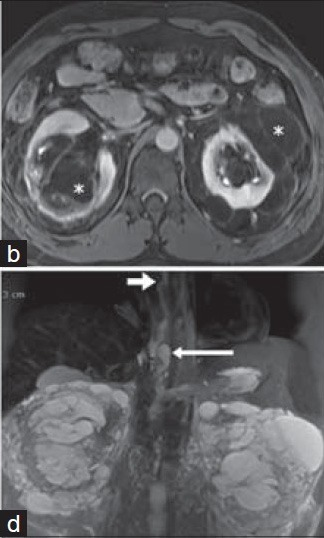

In [76]:
cv2_imshow(segmented_images[1]['image'])

## Full Image Split

The *split_image()* function, uses the rest of the created functions to split the figure by slicing it in the axes x and y.

In [92]:
def split_image(image):

  edges = detect_edges(image)
  image_list = [{'image': image, 'origin': (0,0)}]

  for ax in [0, 1]:
    new_list = []
    for element in image_list:
      limits = find_image_limits(edges, axis = ax)
      split_images = cut_image(element['image'], image_limits = limits, axis = ax, origin = element['origin'])
      for im in split_images:
        new_list.append(im)
    image_list = []
    for element in new_list:
      image_list.append(element)

  return image_list

In [93]:
images = split_image(image)

As we can see, the image was successfully split into four. But there is still one problem: the order is not the correct one.

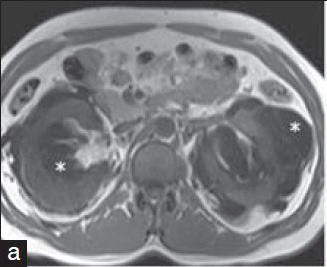

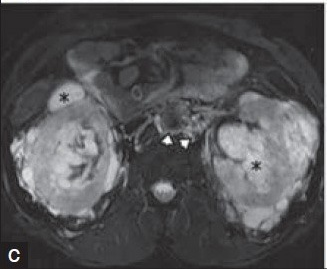

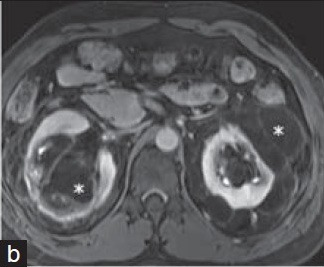

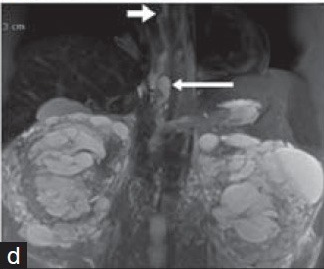

In [98]:
for im in images:
  cv2_imshow(im['image'])
  print('\n')

## Order Sorting

The sort_by_origin() function is used to sort the split images considering their position in the original image, so that the second image is always the one to the right from the first image.

In [50]:
import pandas as pd

In [95]:
  def sort_by_origin(image_list):

    for im in image_list:
      im['distance_from_left'] = im['origin'][0]//50 # A division was added in order to prevent small diferences in any axis to have an impact in the order of the images.
      im['distance_from_top'] = im['origin'][1]//50
    im_df = pd.DataFrame(image_list).sort_values(by=['distance_from_top', 'distance_from_left'])
    im_df['dicts'] = im_df.apply(lambda x: {'image': x['image'], 'origin': x['origin']}, axis=1)
    sorted_image_list = list(im_df['dicts'])

    return sorted_image_list

In [96]:
sorted_images = sort_by_origin(images)

Now the order is correct:

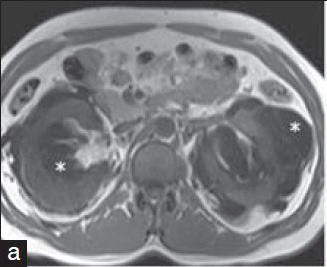

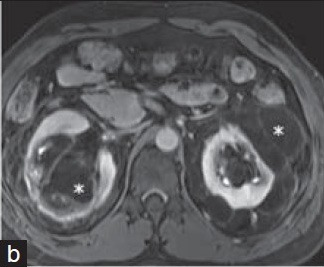

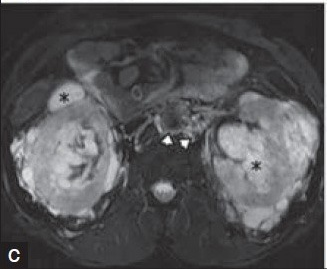

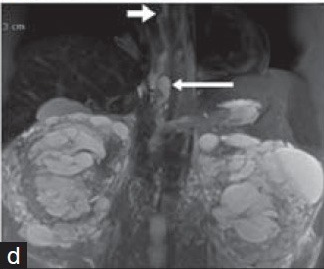

In [99]:
for im in sorted_images:
  cv2_imshow(im['image'])
  print('\n')